In [2]:
import matplotlib.pyplot as plt
import mne

file_path = 'sub-150_ses-001_task-stim_run-01_ieeg_edited_GVE_filtered5.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from /home/ruilin/Desktop/ECE9063/Final/sub-150_ses-001_task-stim_run-01_ieeg_edited_GVE_filtered5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5191167  =      0.000 ...  2534.750 secs...


/tmp/ipykernel_255886/975852390.py:5: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Correlation Matrix:
                     Peaks_First_Channel  Peaks_C131  Variance_C131
Peaks_First_Channel                  NaN         NaN            NaN
Peaks_C131                           NaN    1.000000       0.014223
Variance_C131                        NaN    0.014223       1.000000


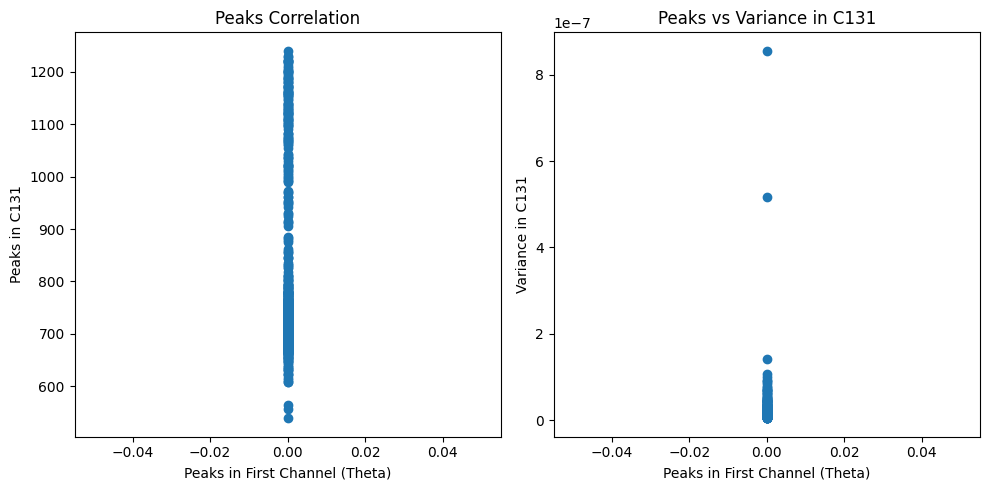

In [4]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks

fs = raw.info['sfreq']

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

data_first_channel = raw.get_data(picks=0)[0]
data_c131 = raw.get_data(picks=4)[0]

# Apply bandpass filter for theta band (4-8 Hz)
theta_filtered = bandpass_filter(data_first_channel, lowcut=4, highcut=8, fs=fs)

# Step 2: Define the 2-second window in terms of samples
window_duration = 2  # 2 seconds
window_samples = int(window_duration * fs)

# Count peaks per 2-second window for both signals
peaks_first_channel = []
peaks_c131 = []
variance_c131 = []

for start in range(0, len(theta_filtered) - window_samples + 1, window_samples):
    # Define the window for both signals
    window_theta = theta_filtered[start:start + window_samples]
    window_c131 = data_c131[start:start + window_samples]
    
    # Count peaks in each window for the first channel (theta band)
    peaks, _ = find_peaks(window_theta)
    peaks_first_channel.append(len(peaks))
    
    # Count peaks in C131 signal
    peaks_c, _ = find_peaks(window_c131)
    peaks_c131.append(len(peaks_c))
    
    # Calculate variance for the C131 window
    variance_c131.append(np.var(window_c131))

# Step 3: Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Peaks_First_Channel': peaks_first_channel,
    'Peaks_C131': peaks_c131,
    'Variance_C131': variance_c131
})

# Step 4: Calculate correlation
correlation_matrix = analysis_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the relationship between peaks in first channel and C131
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(analysis_df['Peaks_First_Channel'], analysis_df['Peaks_C131'])
plt.xlabel('Peaks in First Channel (Theta)')
plt.ylabel('Peaks in C131')
plt.title('Peaks Correlation')

plt.subplot(1, 2, 2)
plt.scatter(analysis_df['Peaks_First_Channel'], analysis_df['Variance_C131'])
plt.xlabel('Peaks in First Channel (Theta)')
plt.ylabel('Variance in C131')
plt.title('Peaks vs Variance in C131')

plt.tight_layout()
plt.show()